In [1]:
"""
Naming convention:

Height: z
Electron Density: ne

Appendices:
Radar measurements: _r (or mimicing the radar resolution)
Truncated lists (to fit required heights): _c
"""


'\nNaming convention:\n\nHeight: z\nElectron Density: ne\n\nAppendices:\nRadar measurements: _r (or mimicing the radar resolution)\nTruncated lists (to fit required heights): _c\n'

In [2]:
#energy dissipation

import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
from scipy.interpolate import LSQUnivariateSpline
from scipy.integrate import quad
from scipy.optimize import minimize
import warnings
import pickle
from time import sleep
from EnergyDissipation import *

%matplotlib widget

printing = 0

importing Jupyter notebook from EnergyDissipation.ipynb


In [3]:
from loadMSIS import *
MSISFile = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'

data_msis = loadMSIS(MSISFile)
[z_msis, n_o1_msis, n_n2_msis, n_o2_msis, mass_density, temp_n_msis, scale_height_msis] = data_msis

importing Jupyter notebook from loadMSIS.ipynb
importing Jupyter notebook from organizing.ipynb


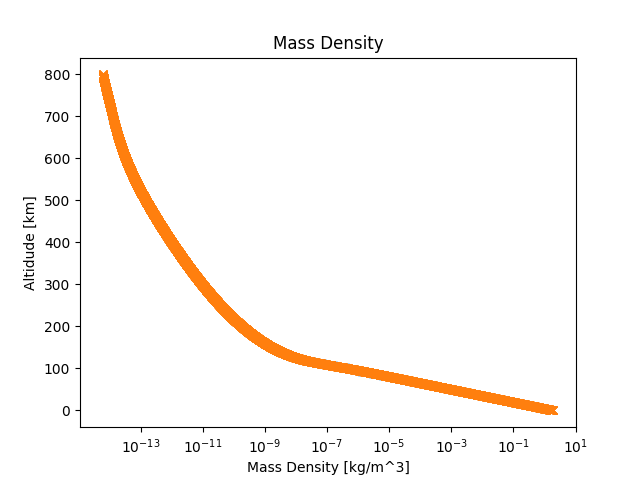

In [4]:
"""interpolating data points to higher resolution"""
#resolution:
res = 100
#interpolating + extrapolating range:
zp = np.arange(0, 800001, res)
hzp = interp1d(z_msis, scale_height_msis, fill_value='extrapolate')(zp)
mdp = np.exp(interp1d(z_msis, np.log(mass_density), fill_value='extrapolate')(zp))
printing = 1
if printing:
    plt.figure()
    plt.title('Mass Density')
    plt.plot(mass_density, z_msis/1e3, 'o-')
    plt.plot(mdp, zp/1e3, 'x-')
    plt.xlabel('Mass Density [kg/m^3]')
    plt.ylabel('Altidude [km]')
    plt.xscale('log')

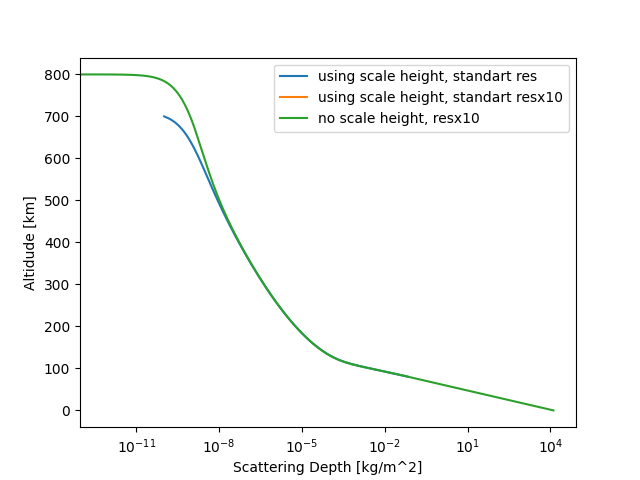

In [5]:
#testing scattering depth:
if printing:
    s = [scattering_depth_sh(mass_density, scale_height_msis, z_msis, z_lower, 0) for z_lower in z_msis]
    sp = [scattering_depth_sh(mdp, hzp, zp, z_lower, 0) for z_lower in zp]
    spp = [scattering_depth(mdp, zp, z_lower, 0) for z_lower in zp]

    
    plt.figure()
    plt.plot(s, z_msis/1e3, label = 'using scale height, standart res')
    plt.plot(sp, zp/1e3, label = 'using scale height, standart resx10')
    plt.plot(spp, zp/1e3, label = 'no scale height, resx10')

    plt.xlabel('Scattering Depth [kg/m^2]')
    plt.ylabel('Altidude [km]')
    plt.xscale('log')
    plt.legend()
    #plt.ylim(50000, 300000)
    plt.plot()

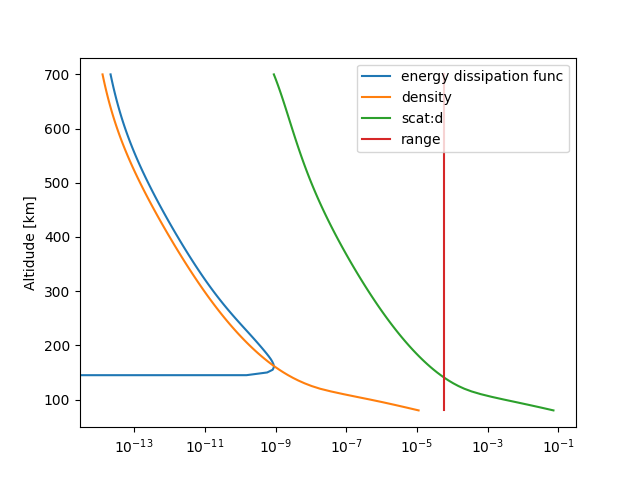

In [6]:
e_mean = 1e3
ar = np.zeros(len(z_msis))

for i in range(len(z_msis)):
    scat_d = scattering_depth(mdp, zp, z_msis[i], 0)
    ran = e_range(e_mean)
    energy_diss = E_diss_func(scat_d, ran)
    ar[i] = energy_diss
    #print(z[i], scat_d, ran, energy_diss)

if printing:
    plt.figure()
    plt.xscale('log')
    plt.plot(ar*mass_density, z_msis/1e3, label='energy dissipation func')
    plt.plot(mass_density, z_msis/1e3, label='density')
    plt.plot([scattering_depth(mdp, zp, z_msis[i], 0) for i in range(len(z_msis))], z_msis/1e3, label='scat:d')
    plt.plot([ran, ran], [z_msis[0]/1e3, z_msis[-1]/1e3], label='range')
    plt.legend()
    plt.ylabel('Altidude [km]')


In [7]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)
e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]

#array of monoenergetic differential fluxes, all with a number flux of 10^12 and energy according to df_meanEnergy
number_flux = 1e10 #[m-2 s-1]
diff_flux = number_flux / e_bin_width

In [8]:
#defining parameters
inc_B = 0
z_min = 80000
z_max = 300000
res_fm = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

printing = 0

"""
Building forward model
"""
def e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B):
    """ 
    builds a forward model for electron production due to a differential flux into the ionosphere accoring
    to Semeter and Kamalabadi (2005).
    
    Parameters:
    z_min: lower altitude of forward model IN METERS
        scalar
    z_max: upper altudute of forward model IN METERS
        scalar
    res_fm: resolution of the forward model in height, used to interpolate density IN METERS
        scalar
    z_sd_min: lower altitude to calculate scattering depth IN METERS
        scalar
    z_sd_max: upper altitude to calculate scattering depth IN METERS
                it is a good idea to provide a z_sd_max larger than z_max (eg. +200km), as the mass density is assumed 
                    to be 0 above that.
                This allows the scattering depth to catch up to reasonable levels at z_max.
                The mass density is extrapolated if not provided at these heights.
        scalar
    res_sd: resolution in height of density in height for calculation of scattering depth IN METERS
        scalar
    e_bin_lims: limits of energy bins
        ndarray
    z_msis: height data of mass_density (height information)
        ndarray
    mass_density: mass_density resolved in height, height given z_msis
        ndarray
    inc_B: inclination of the magnetic field.
        scalar
        
    Returns:
    fm: the forward model and the corresponding heights z_fm 
        ndarray
    z_fm: height, according to z_min, z_max and res_fm
        ndarray
    """
    
    z_fm = np.arange(z_min, z_max, res_fm)
    md_fm = interp_md(z_msis, mass_density, z_fm)
    
    z_sd = np.arange(z_sd_min, z_sd_max, res_sd)
    md_sd = interp_md(z_msis, mass_density, z_sd)
    
    e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
    e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]
    
    fm = np.zeros([len(z_fm), len(e_bin_mean)])
    for i in range(len(z_fm)):
        if i/len(z_fm)%0.1 == 0: print(i/len(z_fm)) 
        #use interpolated values for mass density (mdp) and height (zp)
        scat_d = scattering_depth(md_sd, z_sd, z_fm[i], inc_B)
        for j in range(len(e_bin_mean)):
            ran = e_range(e_bin_mean[j])
            energy_diss = E_diss_func(scat_d, ran)
            fm[i, j] = energy_diss * md_fm[i] * e_bin_mean[j] * e_bin_width[j] / (35.5 * ran)
    return fm, z_fm

fm, z_fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B)
        
if printing:
    plt.figure()
    for i in range(5):
        plt.plot(fm[:, i*100]*diff_flux[i*100], np.arange(z_min, z_max, res_fm)/1e3, label = '%.2f keV' % (e_bin_mean[i*100]/1000))#, marker = '.')
    plt.xscale('log')
    plt.ylabel('Altidude [km]')
    plt.xlabel('Ion production rate [m^-3 s^-1]')
    plt.legend()
    plt.grid()
    #plt.ylim(50, 300)
    #plt.xlim(1e5, 1e11)

#fm.shape

0.0
0.1
0.2
0.4
0.8


In [9]:
if printing:
    #fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 1000
    fm, z_fm  = e_production(70e3,   400e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [10]:
if printing:
    #fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 100
    fm, z_fm = e_production(70e3,   600e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [11]:
if printing:
    #fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 10
    fm, z_fm  = e_production(70e3,   400e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [12]:
if printing:
    #fm =      e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 100
    res_sd = 10
    fm, z_fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [13]:
if printing:
    #fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 10
    res_sd = 10
    fm, z_fm  = e_production(70e3,   600e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [14]:
fm, z_fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B)

0.0
0.1
0.2
0.4
0.8


Insight from testing:
- Use high resolution for scattering depth. Since it is an interpolation and summation, it is fast. Use a higher z_max_sd than z_max, to counter the effect that the upper part of the atmosphere is neglected when calculating the scattering depth.
- Use height resolution of about 100m for forward model to avoid oscillations in energy flux / production rate (should equal to 35.5eV). This is due to resolution of the peak in the ionization profile. Higher resolution does not change much.
- Energy flux / production rate is not equal to energy dissipation per ionization (35.5eV), but 43eV. Reason unknown. One hint is the height of the forward model: Energy lost above z_max is not counted in.
- Use z_max higher tham 400km (preferably 600km), since low energy electrons loose a considerable part of their energy at these heights. From 600km, the difference is negligible. The effect mostly acts of small energies, from 1keV, it becomes negligible.

In [15]:
if printing:
    from scipy.interpolate import CubicSpline
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        cs = CubicSpline(z_fm, prod)
        n = np.arange(z_fm[0], z_fm[-1], 1)
        qp = cs(n)
        e_coll = ener_flux / (np.sum(qp))
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')
    

In [16]:
if printing:
    plt.figure()
    plt.pcolormesh(e_bin_mean/1e3, z_fm/1e3, np.log(fm))
    plt.xscale('log')
    plt.colorbar()
    plt.ylabel('Altidude [km]')
    plt.xlabel('Energy [keV]')
    #plt.ylim(70, 300)
    #plt.xlim(2e-1, 3e1)
    

In [17]:
"""investigate oscillatons in energy flux / production rate ( = aprrox. 35.5 eV)"""
if printing:
    #differential flux: energy binning:
    e_bin_lims_test = np.logspace(4, 4.05, 10)*2
    e_bin_mean_test = (e_bin_lims_test[1:] + e_bin_lims_test[:-1]) / 2
    e_bin_width_test = e_bin_lims_test[1:] - e_bin_lims_test[:-1]
    
    #array of monoenergetic differential fluxes, all with a number flux of 10^12 and energy according to df_meanEnergy
    number_flux_test = 1e12 #[m-2 s-1]
    diff_flux_test = number_flux_test / e_bin_width_test
    
    #fm = e_production(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm_test = 100
    res_sd_test = 10
    fm_test, z_fm_test  = e_production(70e3,   400e3, res_fm_test,   0,        800e3 , res_sd_test, e_bin_lims_test, z_msis, mass_density, inc_B)
    
    fig, ax = plt.subplots(2)
    for i in range(len(e_bin_mean_test)):
        ener_flux_test = number_flux_test*e_bin_mean_test[i]
        prod_test = fm_test[:, i] * diff_flux_test[i]
        ax[0].plot(prod_test, z_fm_test, label = 'E = %.f0 eV' % e_bin_mean_test[i])
        e_coll_test = ener_flux_test / (np.sum(prod_test)*res_fm_test)
        ax[1].plot(e_bin_mean_test[i], e_coll_test, 'x')
    #ax[0].set_xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')
    plt.legend()

299900
20.0


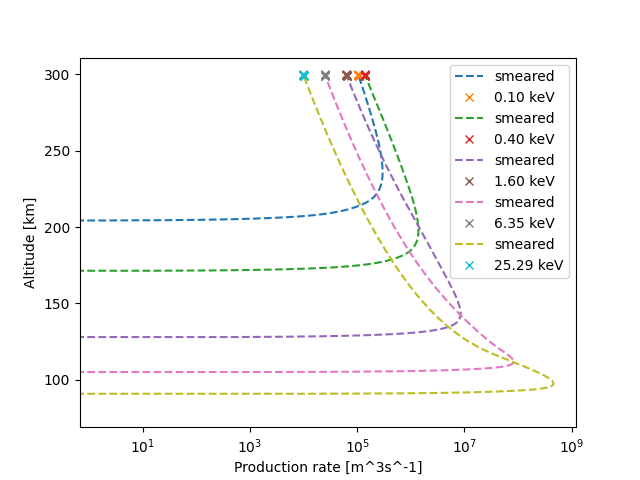

In [18]:
printing = 1
#to simulate pulse smearing (ps), use a gliding average on the production profiles q (= fm[:, i])
pulse_height = 2000
ps_range = pulse_height / res_fm
pulse_smearer = np.ones(np.int_(ps_range))
pulse_smearer = pulse_smearer / np.sum(pulse_smearer) #ensures that the pulse smearer always has norm 1

fm_ps = np.array([np.convolve(height_prof, pulse_smearer, 'same') for height_prof in fm.T]).T
fm_ps[-np.int_(np.ceil(ps_range/2)):, :] = fm[-np.int_(np.ceil(ps_range/2)):, :]
print(z_fm[-1])
print(ps_range)

if printing:
    plt.figure()
    for j in range(np.int_(fm.shape[1]/100)):
        i = j * 100
        plt.plot(fm_ps[:, i]*diff_flux[i], z_fm/1e3, label = 'smeared', ls = '--')
        plt.plot(fm[-11:, i]*diff_flux[i], z_fm[-11:]/1e3, 'x', label = '%.2f keV' % (e_bin_mean[i]/1e3))    
        plt.legend()
        plt.xscale('log')
        plt.xlabel('Production rate [m^3s^-1]')
        plt.ylabel('Altitude [km]')
        

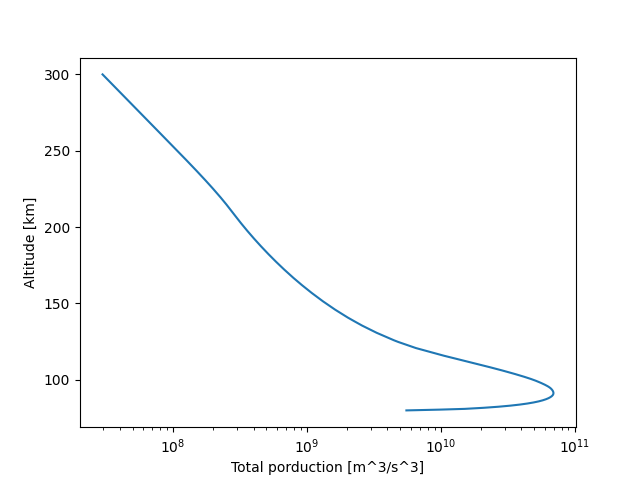

In [19]:
if printing:
    #production q by a differential flux diff_flux: (diff_flux still uniformly defined as above)
    prod = np.dot(fm_ps, diff_flux)
    plt.figure()
    plt.plot(prod, z_fm/1e3)
    plt.xscale('log')
    plt.xlabel('Total porduction [m^3/s^3]')
    plt.ylabel('Altitude [km]')

## Loading of EISCAT data

In [20]:
import scipy.io
from os import listdir
from os.path import isfile, join

import loadEISCAT

#specify your directory of EISCAT data:
path_eiscat_data = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Data/'

[height
 , parameters
 , time
 , az
 , el
 , r_errors ] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_h', 'r_param', 'r_time', 'r_az', 'r_el', 'r_error'])


ne_meas = parameters[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]

#conversion to SI units:
height = height*1e3
#dtime = time[:,0,5] + time[:,0,4]*60 # + time[:,0,3]*3600
r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]
dne = r_errors[:, :, 0]



importing Jupyter notebook from loadEISCAT.ipynb


In [21]:
"""
[powerp_raw
, powerp_err_raw
, powerp_range_raw
, antenna_el
, time_raw] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_pp', 'r_pperr', 'r_pprange', 'r_el', 'r_time'])

con.disable()
if con.print:
    plt.figure()
    plt.plot(powerp_raw.reshape(44, 9, -1)[0], powerp_range_raw.reshape(44, 9, -1)[0], '.', markersize = 1)
    plt.plot(parameters[0, :, 0], z_radar_time[0])
    plt.xlabel('Power Profile [?]')
    plt.ylabel('Range [km]')
    
if con.print:
    plt.figure()
    plt.plot(powerp_range_raw[0])
    

#reshape 1 data dump into the 9 profiles recorded
powerp       = powerp_raw.reshape(powerp_raw.shape[0]*9, -1)
powerp_err   = powerp_err_raw.reshape(powerp_err_raw.shape[0]* 9, -1)
powerp_range = powerp_range_raw.reshape(powerp_range_raw.shape[0]* 9, -1)
time = time_raw[:,0,3]*3600 + time_raw[:,0,4]*60 + time_raw[:,0,5]

if con.print:
    plt.figure()
    plt.plot(powerp[0], powerp_range[0], '.', markersize = 1)
    plt.plot(parameters[0, :, 0], z_radar_time[0])
    plt.xlabel('Power Profile [?]')
    plt.ylabel('Range [km]')
    

dt = 0.443904
r_time = np.array([[t + 0*dt,
                    t + 1*dt,
                    t + 2*dt,
                    t + 3*dt,
                    t + 4*dt,
                    t + 5*dt,
                    t + 6*dt,
                    t + 7*dt,
                    t + 8*dt] for t in time]).reshape(time.shape[0]*9)


#convert range into height
powerp_height = powerp_range * np.sin(antenna_el[0]) * 1e3

#select data from relevant heights
height  = powerp_height[powerp_height<z_max].reshape(powerp_height.shape[0], -1)
ne_meas = powerp[powerp_height<z_max].reshape(powerp_height.shape[0], -1)
dne     = powerp_err[powerp_height<z_max].reshape(powerp_height.shape[0], -1)

del powerp_raw, powerp_err_raw, powerp_range_raw, time_raw
del powerp, powerp_err, powerp_range, powerp_height, time
"""

"\n[powerp_raw\n, powerp_err_raw\n, powerp_range_raw\n, antenna_el\n, time_raw] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_pp', 'r_pperr', 'r_pprange', 'r_el', 'r_time'])\n\ncon.disable()\nif con.print:\n    plt.figure()\n    plt.plot(powerp_raw.reshape(44, 9, -1)[0], powerp_range_raw.reshape(44, 9, -1)[0], '.', markersize = 1)\n    plt.plot(parameters[0, :, 0], z_radar_time[0])\n    plt.xlabel('Power Profile [?]')\n    plt.ylabel('Range [km]')\n    \nif con.print:\n    plt.figure()\n    plt.plot(powerp_range_raw[0])\n    \n\n#reshape 1 data dump into the 9 profiles recorded\npowerp       = powerp_raw.reshape(powerp_raw.shape[0]*9, -1)\npowerp_err   = powerp_err_raw.reshape(powerp_err_raw.shape[0]* 9, -1)\npowerp_range = powerp_range_raw.reshape(powerp_range_raw.shape[0]* 9, -1)\ntime = time_raw[:,0,3]*3600 + time_raw[:,0,4]*60 + time_raw[:,0,5]\n\nif con.print:\n    plt.figure()\n    plt.plot(powerp[0], powerp_range[0], '.', markersize = 1)\n    plt.plot(parameters[0, :, 0], z_

In [22]:
z_r  = height[0]
zr_diff = (z_r[1:]- z_r[:-1])/2
zr_lim = np.array([*z_r, z_r[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])
zr_width = zr_lim[1:] - zr_lim[:-1]
del zr_diff

In [23]:
z_r

array([ 92374.90560658,  94614.86953603,  97633.2313704 , 100279.04824344,
       103279.0769917 , 106475.76389451, 110024.89185123, 114731.53727812,
       120230.63233775, 126004.05717305, 133716.51132423, 142801.02397499,
       152371.73812932, 163044.02399916, 174372.07796207, 186685.23750388,
       200174.43372248, 214617.36710307, 230357.85051871, 246207.50402532,
       264340.39214803, 282895.00782293, 302209.46383458, 322391.71560571,
       344048.5684579 , 366257.48658545, 389494.36159896, 406285.76969339])

In [24]:
zr_lim

array([ 91254.92364185,  93494.8875713 ,  96124.05045321,  98956.13980692,
       101779.06261757, 104877.42044311, 108250.32787287, 112378.21456467,
       117481.08480793, 123117.3447554 , 129860.28424864, 138258.76764961,
       147586.38105216, 157707.88106424, 168708.05098062, 180528.65773297,
       193429.83561318, 207395.90041277, 222487.60881089, 238282.67727202,
       255273.94808668, 273617.69998548, 292552.23582875, 312300.58972015,
       333220.14203181, 355153.02752167, 377875.92409221, 397890.06564618,
       414681.4737406 ])

In [25]:
r_time
"""
import scipy.io
from os import listdir
from os.path import isfile, join

#specify your directory of EISCAT data:
mypath = '/Users/ost051/Documents/PhD/Electron Precipitation/example'
data_path = mypath + '/Data/'
meta_path = mypath + '/Meta-data/'

data_files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f[-3:] == 'mat']
meta_files = [f for f in listdir(meta_path) if isfile(join(meta_path, f))]

n = len(data_files)

mat_data = [scipy.io.loadmat(data_path + file) for file in sorted(data_files)]
        
#initialize lists of data to be extracted:
az = np.zeros([n])
ne = np.zeros([n, 43])
dne = np.zeros([n, 43])
time = np.zeros([n, 2, 6])
height = np.zeros([n, 43, 1])


#load and extract files:
for k, file in enumerate(sorted(data_files)):
    mat = scipy.io.loadmat(data_path + file)
    
    parameters = mat['r_param']
    time[k, :] = mat['r_time']
    height[k, 0:len(mat['r_h'])] = mat['r_h']
    ne[k, 0:len(mat['r_h'])] = parameters[:, 0]
    az[k] = mat['r_az']
    dne[k, 0:len(mat['r_error'])] = mat['r_error'][:, 0]



height = height.reshape([-1,43])
dtime = time[:,0,3] + time[:,0,4]/60 + time[:,0,5]/3600

#see data:
#print(time)
    
#maybe have a look in a single file:
#mat = scipy.io.loadmat(mypath + onlyfiles[0])
#print(mat)
len(height)

dne
"""

"\nimport scipy.io\nfrom os import listdir\nfrom os.path import isfile, join\n\n#specify your directory of EISCAT data:\nmypath = '/Users/ost051/Documents/PhD/Electron Precipitation/example'\ndata_path = mypath + '/Data/'\nmeta_path = mypath + '/Meta-data/'\n\ndata_files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f[-3:] == 'mat']\nmeta_files = [f for f in listdir(meta_path) if isfile(join(meta_path, f))]\n\nn = len(data_files)\n\nmat_data = [scipy.io.loadmat(data_path + file) for file in sorted(data_files)]\n        \n#initialize lists of data to be extracted:\naz = np.zeros([n])\nne = np.zeros([n, 43])\ndne = np.zeros([n, 43])\ntime = np.zeros([n, 2, 6])\nheight = np.zeros([n, 43, 1])\n\n\n#load and extract files:\nfor k, file in enumerate(sorted(data_files)):\n    mat = scipy.io.loadmat(data_path + file)\n    \n    parameters = mat['r_param']\n    time[k, :] = mat['r_time']\n    height[k, 0:len(mat['r_h'])] = mat['r_h']\n    ne[k, 0:len(mat['r_h'])] = paramete

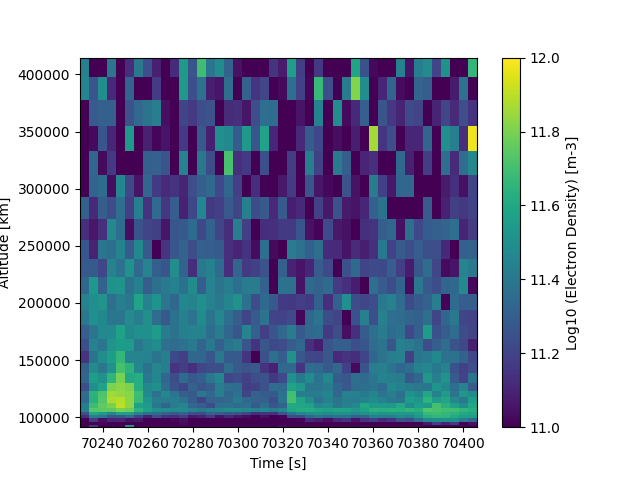

In [26]:
if printing:
    plt.figure()
    plt.pcolormesh(r_time, height[0], np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

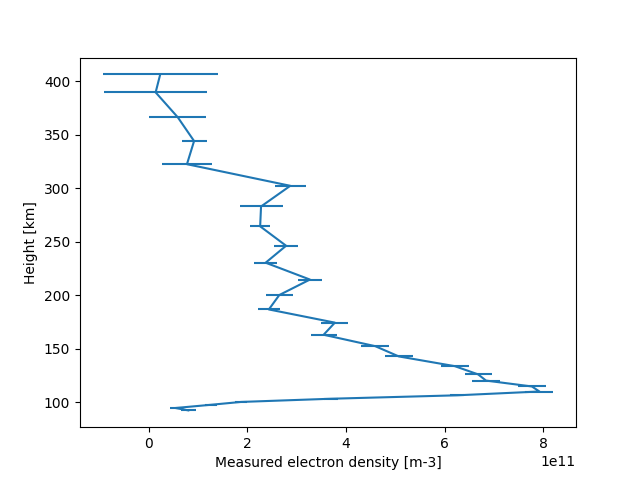

In [27]:
if printing:
    plt.figure()
    plt.errorbar(ne_meas[4], height[0]/1e3, xerr = dne[4])
    plt.xlabel('Measured electron density [m-3]')
    plt.ylabel('Height [km]')

## Load IRI data:

In [28]:
from loadIRI import *

#read IRI file
iri_file = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'

[z_iri     
, ne_iri    
, t_neutral 
, t_ion     
, t_e       
, rel_o_p   
, rel_n_p   
, rel_h_p   
, rel_he_p  
, rel_o2_p  
, rel_no_p] = loadIRI(iri_file)

importing Jupyter notebook from loadIRI.ipynb


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_14463/45377229.py:2: RuntimeWarning: invalid value encountered in power
  no_p_recr = 2.1e-13 * (t_e/300)**(-0.85)
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_14463/45377229.py:3: RuntimeWarning: invalid value encountered in power
  o2_p_recr = 1.9e-13 * (t_e/300)**(-0.5)


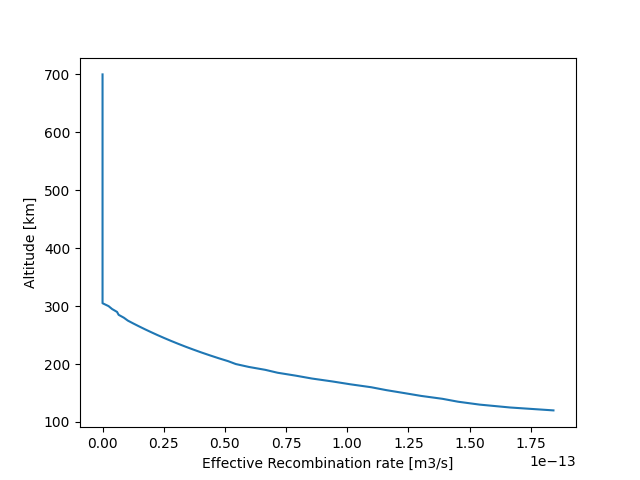

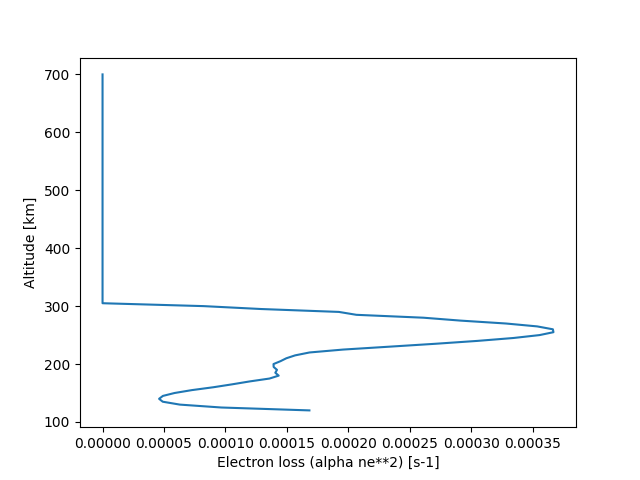

In [29]:
#effective recombination rate:
no_p_recr = 2.1e-13 * (t_e/300)**(-0.85)
o2_p_recr = 1.9e-13 * (t_e/300)**(-0.5)

eff_recr = rel_no_p * no_p_recr + rel_o2_p * o2_p_recr
printing = 1
if printing:
    plt.figure()
    plt.plot(eff_recr, z_iri/1e3)
    plt.ylabel('Altitude [km]')
    plt.xlabel('Effective Recombination rate [m3/s]')
    
if printing:
    plt.figure()
    plt.plot(eff_recr*ne_iri, z_iri/1e3)
    plt.ylabel('Altitude [km]')
    plt.xlabel('Electron loss (alpha ne**2) [s-1]')

In [30]:
#interpolate electron density for first estimate, and effective recombination for general use:
ne_iri_fm = CubicSpline(z_iri, ne_iri)(z_fm)
err_fm = CubicSpline(z_iri, eff_recr)(z_fm)

#correct for netgative values:
ne_iri_fm = np.array([n if n>0 else 0 for n in ne_iri_fm])

if printing:
    plt.figure()
    plt.plot(ne_iri_fm, z_fm/1e3)
    plt.plot(ne_iri, z_iri/1e3, 'x')
    plt.xlabel('Electron density (IRI) [m-3]')
    plt.ylabel('Altitude [km]')
    plt.xscale('log')

ValueError: `y` must contain only finite values.

In [ ]:
eff_recr

In [ ]:
dndt = np.dot(fm_ps, diff_flux) - err_fm * ne_iri_fm**2 
ne_iri_fm + dndt
if printing:
    plt.figure()
    plt.plot(ne_iri_fm, z_fm, label = 'interpolated Ne IRI')
    plt.plot(dndt, z_fm, label = 'dn/dt')
    plt.plot(ne_iri_fm + dndt, z_fm, label = 'ne + dn/dt')
    plt.plot(ne_meas[1], height[1], label = 'ne_meas')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Electron Density [m-3]')
    plt.ylabel('Altitude [km]')


In [ ]:
def sos(param, ne_meas, var,  dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = maxwell_diff_flux(e_bin_mean, *param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_fm, ne_tp1, zr_lim[i], zr_lim[i+1])
    sumofs = np.sum((ne_meas - ne_int)**2 / var**2)
    return sumofs
    
def sum_of_squares(model, variable, meas, variances):
    """
    Calculates the Sum of Squares
    
    Parameters:
    model: model values
        ndarray (len(meas))
    meas: measurement values
        ndarray 
    varainces: variances of measurements
        ndarray (len(meas))
    """
    model_values = model(variable)
    sum_o_s = np.sum((meas - model)**2 / variances**2)
    return sum_o_s

In [ ]:
if printing:
    plt.figure()
    plt.plot(e_bin_mean, diff_flux)
    plt.yscale('log')
    plt.xscale('log')
    
    plt.figure()
    plt.bar(e_bin_mean, diff_flux, width = e_bin_width)#, edgecolor = 'black')
    plt.yscale('log')
    plt.xscale('log')

In [ ]:
def ne_height_int(z_fm, ne_tp1, z0, z1):
    """
    Calculates the mean electron density as the radar would measure it,
    from a high resolved height profile (z_fm, ne_tp1) 
    to one measurement between [z0, z1]
    
    Parameters:
    z_fm: list of heights along which the  electron density is known
        ndarray
    ne_tp1: list of electron density along the heights given by z_fm
        ndarray
    z0: lower integration boundary
        scalar
    z1: upper integration boundary
        scalar
        
    Returns:
    ne_int: The height integrated electron density, normalized by the difference z0-z1
    """
    #if (ne_tp1<0).any(): raise RuntimeError('Negative Electron Density')
    res = 1 # resolution in meters
    z = np.arange(z0, z1, res)
    ne_ip = interp1d(z_fm, ne_tp1)(z)
    ne_int = (np.sum(ne_ip) * res + ne_ip[-1] * (z1 - (z[-1]+res))) / (z1 -z0)
    #if (ne_int<0).any(): raise RuntimeError('Negative Electron Density')
    return ne_int

ne_int = np.zeros(len(z_r))
for i in range(len(z_r)):
    ne_int[i] = ne_height_int(z_fm, ne_iri_fm, zr_lim[i], zr_lim[i+1])
    
if printing:
    plt.figure()
    plt.plot(ne_iri_fm, z_fm/1e3, label = 'high res')
    plt.plot(ne_int, z_r/1e3, 'x', label = 'radar res')
    plt.legend()

In [ ]:
ne_int

# research energy distribution!!

In [ ]:
def maxwell_diff_flux(e, i0, e0, delta_e, gamma):
    """
    Calculates the differential flux as (roughly) maxwellian distributed.
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    i0: maximum flux [eV-1 m-2 s-1]
        scalar
    e0: energy of maximum flux [eV]
        scalar
    delta_e: with of distribution [eV]
        scalar
    gamma: exponent, 2 for a maxwellian
        scalar
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    e = e.astype(complex)
    diff_flux = np.abs(i0 * np.exp(-((e - e0)/delta_e)**gamma))
    return diff_flux


def pol_diff_flux(e, p):
    """
    Calculates the differential flux as  E*exp(plonimonial in E)
    Polynomial of second degree
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    p: coefficients as a list
        ndarray
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2)
    return diff_flux


def pol3_diff_flux(e, p):
    """
    Calculates the differential flux as  E*exp(plonimonial in E)
    Polynomial of third degree
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    p: coefficients as a list
        ndarray
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2 + p[3]*e**3)
    return diff_flux

def pol_diff_flux_kev(e, p):
    """
    Calculates the differential flux as  E*exp(plonimonial in E)
    Polynomial of second degree
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    p: coefficients as a list IN [keV^-1] TO SCALE THE VALUES OF P CLOSER TO 1!
        ndarray
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    ke = e/1e3
    diff_flux = e * np.exp(p[0] + p[1]*ke + p[2]*ke**2)
    return diff_flux


def pol3_diff_flux_kev(e, p):
    """
    Calculates the differential flux as  E*exp(plonimonial in E)
    Polynomial of third degree
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    p: coefficients as a list IN [keV^-1] TO SCALE THE VALUES OF P CLOSER TO 1!
        ndarray
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    ke = e/1e3
    diff_flux = e * np.exp(p[0] + p[1]*ke + p[2]*ke**2 + p[3]*ke**3)
    return diff_flux

In [ ]:
maxwell_diff_flux(e_bin_mean, 10, 1e3, 1e2, 2)
plt.figure()
plt.plot(e_bin_mean, maxwell_diff_flux(e_bin_mean, 100, 2e3, 1e2, 2))
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, [0, 0.01, -0.000002]))
plt.yscale('log')
plt.xscale('log')

In [ ]:
#clip the models in altitude
cutoff_ind = np.where(z_fm == 200000)[0][0]
z_c = z_fm[:cutoff_ind]
fm_c = fm_ps[:cutoff_ind]

err_c = err_fm[:cutoff_ind]
#ne_mod_c = ne_mod[:cutoff_ind] #difened later, and wrong actually => TODO
#ne_mod_c = np.zeros(len(z_c))

cutoff_ind_r = np.where(z_r >= 200000)[0][0]
z_r_c = z_r[:cutoff_ind_r]
zr_lim_c = zr_lim[:cutoff_ind_r+1]
ne_meas_c = ne_meas[:, :cutoff_ind_r]
dne_c = dne[:, :cutoff_ind_r]


In [ ]:
def e_production_n0(z_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B):
    """ 
    builds a forward model for electron production due to a differential flux into the ionosphere accoring
    to Semeter and Kamalabadi (2005).
    
    Parameters:
    z_fm: heights where the forward model is evaluated
        ndarray
    df_par: parameters of the differential flux model
        ndarray
    z_sd_min: lower altitude to calculate scattering depth IN METERS
        scalar
    z_sd_max: upper altitude to calculate scattering depth IN METERS
        scalar
    res_sd: resolution in height of density in height for calculation of scattering depth IN METERS
        scalar
    e_bin_lims: limits of energy bins
        ndarray
    z: parametrization of mass_density (height information)
        ndarray
    mass_density: mass_density resolved in height, parametrized by z
        ndarray
    inc_B: inclination of the magnetic field.
        scalar
        
    Returns:
    fm, the forward model and the corresponding heights z_fm 
    """
    md_fm = interp_md(z_msis, mass_density, z_fm)
    
    z_sd = np.arange(z_sd_min, z_sd_max, res_sd)
    md_sd = interp_md(z_msis, mass_density, z_sd)
    
    e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
    e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]
    
    fm = np.zeros([len(z_fm), len(e_bin_mean)])
    for i in range(len(z_fm)):
        if i/len(z_fm)%0.1 == 0: print(i/len(z_fm)) 
        #use interpolated values for mass density (mdp) and height (zp)
        scat_d = scattering_depth(md_sd, z_sd, z_fm[i], inc_B)
        for j in range(len(e_bin_mean)):
            ran = e_range(e_bin_mean[j])
            energy_diss = E_diss_func(scat_d, ran)
            fm[i, j] = energy_diss * md_fm[i] * e_bin_mean[j] * e_bin_width[j] / (35.5 * ran)
    return fm, z_fm


fm_0, z_fm_0 = e_production_n0(z_r_c, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B)

if printing:
    plt.figure()
    for i in range(5):
        plt.plot(fm_0[:, i*100]*diff_flux[i*100], z_r_c/1e3, label = '%.2f keV' % (e_bin_mean[i*100]/1000))#, marker = '.')
    plt.xscale('log')
    plt.ylabel('Altidude [km]')
    plt.xlabel('Ion production rate [m^-3 s^-1]')
    plt.legend()
    plt.grid()
    #plt.ylim(50, 300)
    #plt.xlim(1e5, 1e11)



In [ ]:
r_time

In [ ]:
"""
first estimate of ne_mod
"""
printing = 0

#[u, s, vh] = np.linalg.svd(fm_0)
#v = vh.T
#
##moore penrose pseudo-inverse:
#s_inv = np.zeros([vh.shape[0], u.shape[0]])
#s_inv[:len(s), :len(s)] = np.diag(s/(s**2 + 10**2))
#fm_pinv = np.dot(v, np.dot(s_inv, u.T))

err_r_c = CubicSpline(z_iri, eff_recr)(z_r_c)

def sos_ne0(par, e_bin_mean, ne_obs, std, fm_0, err_0):
    diff_flux = pol_diff_flux_kev(e_bin_mean, par)
    ne_mod = np.sqrt(np.dot(fm_0, diff_flux)/err_0)
    s = np.sum((ne_obs - ne_mod)**2/std**2)
    return s

param = [10, 0.00001, -0.000000001]
param = [ 1.82498519e+01, -4.24869475e-01, -4.35589291e-8]

result_t0 = minimize(sos_ne0, 
                param,
                method = 'Nelder-Mead',
                bounds = [(None, None),(None, None),(-np.inf, 0)], 
                args=(e_bin_mean, ne_meas_c[0], dne_c[0], fm_0, err_r_c)
                )

print(result_t0.x)

ne_mod0 = np.sqrt(np.dot(fm_c, pol_diff_flux_kev(e_bin_mean, result_t0.x))/err_c)
  
print([(ind, i) for ind, i in enumerate(np.dot(fm_c, pol_diff_flux_kev(e_bin_mean, result_t0.x))/err_c) if i<0])
print(fm_ps[fm_ps<0])
print(fm[fm<0])

ne_fit_r = np.array([ne_height_int(z_c, ne_mod0, zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
red_chi2 = np.sum((ne_meas_c[0] -  ne_fit_r)**2 / dne_c[0]**2) / (len(z_r) - 3)
print(red_chi2)


plt.figure()
plt.plot(ne_meas_c[0], z_r_c, 'x')
plt.plot(ne_mod0, z_c)

plt.figure()
plt.plot(e_bin_mean, pol_diff_flux_kev(e_bin_mean, param))

plt.xscale('log')
plt.yscale('log')

In [ ]:
def sos2(param, ne_meas, std,  dt, t0, t1, fm_ps, ne_0, eff_recr, z_r, zr_lim, z_ne_mod):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    std: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = pol_diff_flux_kev(e_bin_mean, param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
            #ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    if (ne_tp1<0).any(): raise RuntimeError('Negative Electron Density')
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_ne_mod, ne_tp1, zr_lim[i], zr_lim[i+1])

    #print(ne_meas)
    #print(ne_int)
    #print(var)
    sumofs = np.sum((ne_meas - ne_int)**2 / std**2)

    return sumofs

def ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Integration of the electron density in time:
    ne(t+dt) = ne(t) + dne/dt * dt = ne_0 + (A.phi - alpha ne**2) * dt 
    
    Paramters:
    diff_flux: phi: differential number flux
        ndarray
    dt: length of the time step to integrate
        scalar
    t0: start time fo integration
        scalar
    t1: end of integration
        scalar
    fm_ps: A: forward model to desribe production profile q = A.phi
        ndarray (len(z_fm) x len(diff_flux))
    ne_0: ne(t = t0): electron density as height profile at the start
        nd_array (len(z_fm))
    eff_recr: alpha: effective recombination rate as a height profile
        ndarray (len(z_fm))
    
    Returns:
    The integrated electron density after dt: ne(t+dt)
    """
    t = t0
    while t < t1:
        dnedt = np.dot(fm_ps, diff_flux) - eff_recr * ne_0**2
        ne = ne_0 + dnedt * dt
        
        t = t + dt
        ne_0 = ne
    return ne

In [ ]:
#time steps for integration in seconds:


with open('/Users/ost051/Documents/PhD/Electron Precipitation/fit_results.pickle', 'rb') as f:
    #fit = pickle.load(f)
    [fit, ne_fit] = pickle.load(f)

delta_t = 0.01


#fit = []
#fit.append(result_t0)
#ne_fit = np.empty([len(r_time), len(z_c)])
#ne_mod_c = ne_mod0
#ne_fit[0] = ne_mod_c
#
#if printing:
#    fig = plt.figure()
#    
#    
#param = result_t0.x
##param = [0, 0.01, -0.000002]
##             x: array([-2.31760126e-02,  2.63704831e-03, -1.40279493e-07]) old values, update
#
#for ind in range(len(r_time)-1):
#    print(ind, 'of', len(r_time)-1, 'time = ', r_time[ind+1])
#    
#    result = minimize(sos2, 
#                      param,
#                      method = 'Nelder-Mead',
#                      bounds = [(None, None),(None, None),(-np.inf, 0)], 
#                      args=(ne_meas_c[ind+1], dne_c[ind+1]**2, delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c, z_r_c, zr_lim_c, z_c)
#                           #ne_meas,           var,         dt,      t0,          t1,            fm_ps, ne_0,   eff_recr, z_r, zr_lim,   z_ne_mod):
#                     )
#    fit.append(result)
#    print(fit[ind])
#
##    result = minimize(sos, 
##                      param,
##                      method = 'Nelder-Mead',
##                      bounds = [(0, np.inf),(0, np.inf),(0, np.inf),(0.5, 5)], 
##                      args=(ne_meas[i+1], dne[i+1], delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
##                     )
#    
#    #prepare for next iteration:
#    diff_flux = pol_diff_flux_kev(e_bin_mean, result.x)
#    ne_tp1 = ne_time_int(diff_flux, delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c)
#    ne_mod_c = ne_tp1
#    param = result.x
#    if param[-1] == 0: param[-1] = -7.40343286e-04
#    
#    ne_fit[ind+1, :] = ne_tp1
#    
#           
#    """
#    Check reduced chi^2
#    """
#    ne_fit_r = np.array([ne_height_int(z_c, ne_tp1, zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
#    red_chi2 = np.sum((ne_meas_c[ind+1] -  ne_fit_r)**2 / dne_c[ind+1]**2) / (len(z_r) - 3)
#    print('Red. chi2:', red_chi2)
#    
#with open('/Users/ost051/Documents/PhD/Electron Precipitation/fit_results.pickle', 'wb') as f:
#    pickle.dump([fit, ne_fit], f, protocol=pickle.HIGHEST_PROTOCOL)
#
#if printing == 1:
#    plt.legend()

In [ ]:
"""
check residual distribuiton
"""
res = np.zeros([len(r_time), len(z_r_c)])
for ind in range(len(r_time)):
    ne_fit_r = np.array([ne_height_int(z_c, ne_fit[ind], zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
    res[ind] = ne_meas_c[ind] -  ne_fit_r

print(np.max(res))


from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

# Create new Figure and an Axes which fills it.
fig, ax = plt.subplots()

h = ax.hist(res[0], label = 'Histogramm of Residuals')
ax.legend()

def update(frame_number):
    ax.cla()
    ax.set_xlim([-4e11, 4e11])
    ax.set_ylim([0, 8])
    h = ax.hist(res[frame_number], label = 'Histogramm of Residuals')
    return h

animation = FuncAnimation(fig, update, frames = np.arange(len(res)), interval=200, blit = False)
display(HTML(animation.to_jshtml(default_mode='loop')))
plt.close()  # avoid spurious figure display




In [ ]:
"""
Check reduced chi^2
"""
for ind in range(len(r_time)):
    ne_fit_r = np.array([ne_height_int(z_c, ne_fit[ind], zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
    red_chi2 = np.sum((ne_meas_c[ind] -  ne_fit_r)**2 / dne_c[ind]**2) / (len(z_r) - 3)
    print(red_chi2)

In [ ]:
print(ne_fit.shape)
plt.figure()
plt.pcolormesh(r_time, z_c/1e3, np.log10(ne_fit.T), vmin = 11, vmax = 12)
plt.colorbar()
plt.ylabel('Altidude [km]')
plt.xlabel('Time [s]')
plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()

if printing:
    plt.figure()
    plt.pcolormesh(r_time, height[0]/1e3, np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

In [ ]:
#energy time plot
plt.figure()
plt.pcolormesh(r_time, e_bin_mean, np.array([np.log10(pol_diff_flux_kev(e_bin_mean, result.x)) for result in fit]).T, vmin = 8, vmax = 12.5)
plt.colorbar()
plt.ylabel('Energy [ev]')
plt.xlabel('Time [s]')
plt.yscale('log')
#plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()



In [ ]:
"""
Check if all fits have terimnated successfully
"""
for k, f in enumerate(fit):
    if f.success == False:
        print('Fit n.', k, 'has terminated unsuccessfully.')


In [ ]:
plt.figure()
plt.plot(ne_fit[0], z_c/1e3)
#plt.plot(ne_fit[1], z_c/1e3)

plt.xscale('log')

In [ ]:
plt.figure()
plt.plot(e_bin_mean, pol_diff_flux_kev(e_bin_mean, fit[2].x))
plt.yscale('log')
plt.xscale('log')

In [ ]:
fit[1]

In [ ]:
for f in fit:
    print(f.x)

In [ ]:
for f in fit:
    par = f.x
    diff_flux = pol_diff_flux_kev(e_bin_mean, par)
#result.x

In [ ]:
plt.figure()
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, [ 9.30941045e-03,  2.82050985e-03, -1.38052857e-07]))
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.figure()
for i, f in enumerate(fit):
    plt.plot(e_bin_mean, pol_diff_flux_kev(e_bin_mean, f.x)* 10**(2*i))
plt.yscale('log')
plt.xscale('log')

In [ ]:
with open('/Users/ost051/Documents/PhD/Electron Precipitation/fit_results.pickle', 'rb') as f:
    #fit = pickle.load(f)
    [fit, ne_fit] = pickle.load(f)

In [ ]:
"""
using pol3

first estimate of ne_mod
"""
printing = 1

#[u, s, vh] = np.linalg.svd(fm_0)
#v = vh.T
#
##moore penrose pseudo-inverse:
#s_inv = np.zeros([vh.shape[0], u.shape[0]])
#s_inv[:len(s), :len(s)] = np.diag(s/(s**2 + 10**2))
#fm_pinv = np.dot(v, np.dot(s_inv, u.T))

err_r_c = CubicSpline(z_iri, eff_recr)(z_r_c)

def sos_ne0_p3(par, e_bin_mean, ne_obs, std, fm_0, err_0):
    diff_flux = pol3_diff_flux_kev(e_bin_mean, par)
    ne_mod = np.sqrt(np.dot(fm_0, diff_flux)/err_0)
    s = np.sum((ne_obs - ne_mod)**2/std**2)
    return s

param = [10, 0.00001, -0.000000001, -0.000000000000001]
param = [ 1.86421376e+01, -5.16833339e-01,  4.15756160e-03, -8.02510832e-5]


result_t0 = minimize(sos_ne0_p3, 
                param,
                method = 'Nelder-Mead',
                bounds = [(None, None),(None, None),(-np.inf, np.inf),(-np.inf, 0)], 
                args=(e_bin_mean, ne_meas_c[0], dne_c[0], fm_0, err_r_c)
                )

print(result_t0.x)

ne_mod0 = np.sqrt(np.dot(fm_c, pol3_diff_flux_kev(e_bin_mean, result_t0.x))/err_c)
  
print([(ind, i) for ind, i in enumerate(np.dot(fm_c, pol3_diff_flux_kev(e_bin_mean, result_t0.x))/err_c) if i<0])
print(fm_ps[fm_ps<0])
print(fm[fm<0])

ne_fit_r = np.array([ne_height_int(z_c, ne_mod0, zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
red_chi2 = np.sum((ne_meas_c[0] -  ne_fit_r)**2 / dne_c[0]**2) / (len(z_r) - 4)
print(red_chi2)

plt.figure()
plt.errorbar(ne_meas_c[0], z_r_c, xerr = dne_c[0], marker = 'x', linestyle = ' ')
plt.plot(ne_mod0, z_c)

plt.figure()
plt.plot(e_bin_mean, pol3_diff_flux_kev(e_bin_mean, param))
plt.plot(e_bin_mean, pol3_diff_flux_kev(e_bin_mean, result_t0.x))

plt.xscale('log')
plt.yscale('log')

In [ ]:
def sos2_p3(param, ne_meas, std,  dt, t0, t1, fm_ps, ne_0, eff_recr, z_r, zr_lim, z_ne_mod):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = pol3_diff_flux_kev(e_bin_mean, param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
            #ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    if (ne_tp1<0).any(): 
        return 2**30
        #raise RuntimeError('Negative Electron Density')
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_ne_mod, ne_tp1, zr_lim[i], zr_lim[i+1])

    #print(ne_meas)
    #print(ne_int)
    #print(var)
    sumofs = np.sum((ne_meas - ne_int)**2 / std**2)

    return sumofs

In [ ]:
#time steps for integration in seconds:
delta_t = 0.01


with open('/Users/ost051/Documents/PhD/Electron Precipitation/fit3_results.pickle', 'rb') as f:
    #fit = pickle.load(f)
    [fit3, ne_fit3] = pickle.load(f)
    
    

#fit3 = []
#fit3.append(result_t0)
#ne_fit3 = np.empty([len(r_time), len(z_c)])
#ne_mod_c = ne_mod0
#ne_fit3[0] = ne_mod_c
#
#
#if printing:
#    fig = plt.figure()
#
#param = result_t0.x
#
#for ind in range(len(r_time)-1):
#    print(ind, 'of', len(r_time)-1, 'time = ', r_time[ind+1])
#    
#    result = minimize(sos2_p3, 
#                      param,
#                      method = 'Nelder-Mead',
#                      bounds = [(None, None),(None, None),(None, None),(-np.inf, 0)], 
#                      args=(ne_meas_c[ind+1], dne_c[ind+1], delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c, z_r_c, zr_lim_c, z_c)
#                           #ne_meas,           var,         dt,      t0,          t1,            fm_ps, ne_0,   eff_recr, z_r, zr_lim,   z_ne_mod):
#                     )
#    fit3.append(result)
#    print(fit3[ind])
#
##    result = minimize(sos, 
##                      param,
##                      method = 'Nelder-Mead',
##                      bounds = [(0, np.inf),(0, np.inf),(0, np.inf),(0.5, 5)], 
##                      args=(ne_meas[i+1], dne[i+1], delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
##                     )
#    
#    #prepare for next iteration:
#    diff_flux = pol3_diff_flux_kev(e_bin_mean, result.x)
#    ne_tp1 = ne_time_int(diff_flux, delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c)
#    ne_mod_c = ne_tp1
#    param = result.x
#    if param[-1] == 0: param[-1] = -7.40343286e-05
#    
#    ne_fit3[ind+1, :] = ne_tp1
#    
#    """
#    Check reduced chi^2
#    """
#    ne_fit_r = np.array([ne_height_int(z_c, ne_tp1, zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
#    red_chi2 = np.sum((ne_meas_c[ind+1] -  ne_fit_r)**2 / dne_c[ind+1]**2) / (len(z_r) - 4)
#    print('Red. chi2:', red_chi2)
#    
#    
#with open('/Users/ost051/Documents/PhD/Electron Precipitation/fit3_results.pickle', 'wb') as f:
#    pickle.dump([fit3, ne_fit3], f, protocol=pickle.HIGHEST_PROTOCOL)
#
#if printing == 1:
#    plt.legend()

In [ ]:
print(ne_fit.shape)
plt.figure()
plt.pcolormesh(r_time, z_c/1e3, np.log10(ne_fit.T), vmin = 11, vmax = 12)
plt.colorbar()
plt.ylabel('Altidude [km]')
plt.xlabel('Time [s]')
plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()

if printing:
    plt.figure()
    plt.pcolormesh(r_time, height[0]/1e3, np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

In [ ]:
for f in fit3:
    print(f.x)

In [ ]:
#energy time plot
plt.figure()
plt.pcolormesh(r_time, e_bin_mean, np.array([np.log10(pol3_diff_flux_kev(e_bin_mean, result.x)) for result in fit3]).T, vmin = 8, vmax = 12.5)
plt.colorbar()
plt.ylabel('Energy [ev]')
plt.xlabel('Time [s]')
plt.yscale('log')
#plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()




In [ ]:
res3 = np.zeros([len(r_time), len(z_r_c)])
for ind in range(len(r_time)):
    ne_fit_r = np.array([ne_height_int(z_c, ne_fit3[ind], zr_lim_c[i], zr_lim_c[i+1]) for i in range(len(z_r_c))])
    res3[ind] = ne_meas_c[ind] -  ne_fit_r

from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

# Create new Figure and an Axes which fills it.
fig, ax = plt.subplots()

x = np.arange(-10, 10, 0.1)

h = ax.hist(res3[0], label = 'Histogramm of Residuals')
l = ax.plot(x, np.exp(-(x**2)/2)/np.sqrt(2*np.pi)*len(res3.flat))
ax.legend()

def update(frame_number):
    ax.cla()
    #ax.set_xlim([-4e11, 4e11])
    ax.set_ylim([0, 8])
    h = ax.hist(res3[frame_number]/dne_c[frame_number], label = 'Histogramm of Residuals')
    l = ax.plot(x, np.exp(-(x**2)/2)/np.sqrt(2*np.pi)*len(res[frame_number].flat))
    return h, l

animation = FuncAnimation(fig, update, frames = np.arange(len(res)), interval=200, blit = False)
display(HTML(animation.to_jshtml(default_mode='loop')))
plt.close()  # avoid spurious figure display

In [ ]:
np.exp(-(x**2)/2)/np.sqrt(2*np.pi)

In [ ]:
plt.figure()
plt.hist((res3/dne_c).flat, bins = 20)
plt.plot(x, np.exp(-(x**2)/2)/np.sqrt(2*np.pi)*len(res3.flat))

In [ ]:
plt.figure()
plt.hist((res/dne_c).flat, bins = 20)
plt.plot(x, np.exp(-(x**2)/2)/np.sqrt(2*np.pi)*len(res3.flat))

## Ionopsheric Chemistry

In [ ]:
"""
Preparation (could be written as module)
- load file with reaction and species information, inkl. stochiometry and charges etc.
- produce classes with sepcies concentration etc
- produce classes with reaction information
"""
import numpy as np
from datetime import datetime
import os
import import_ipynb
from ionChem import *
model = 


In [ ]:
for c in all_species:
    print(c.name, getConstituentsIDByName([c.name]))

In [ ]:
"""
#todo:
- model for Te, Ti, Tr (altitude and evolution)
- density as a vector
- production from ionizing radiation

"""
err_fm = CubicSpline(z_iri, eff_recr)(z_fm)

rel_o_p       #[O+ percentage of ions]
rel_n_p       #[N+ percentage of ions]
rel_h_p       #[H+ percentage of ions]
rel_he_p      #[He+ percentage of ions]
rel_o2_p      #[O2+ percentage of ions]
rel_no_p      #[NO+ percentage of ions]

n_o1_msis    #[number density in m^-3]
n_n2_msis    #[number density in m^-3]
n_o2_msis    #[number density in m^-3]

print(len(rel_o_p))
print(len(n_o1_msis))
print(len(err_c))

In [ ]:
len(z_c)

In [ ]:
assign_densities(z_c
                     , z_msis
                     , z_iri
                     , n_o1_msis
                     , n_n2_msis
                     , n_o2_msis    
                     , ne_iri        
                     , rel_o_p   
                     , rel_n_p   
                     , rel_h_p   
                     , rel_he_p  
                     , rel_o2_p  
                     , rel_no_p)

In [ ]:
#assign densities to species
printing = 1
print(all_species[1].name)
all_species[1].density = np.exp(CubicSpline(z_msis, np.log(n_o1_msis))(z_c))
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    plt.plot(n_o1_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
    plt.plot(all_species[1].density, z_c/1e3, label = 'interp')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O' + all_species[1].name)
    plt.legend()


print(all_species[3].name)
all_species[3].density = CubicSpline(z_msis, n_o2_msis)(z_c)
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    plt.plot(n_o2_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
    plt.plot(all_species[3].density, z_c/1e3, label = 'interp')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O2')
    plt.legend()

print(all_species[7].name)
all_species[7].density = CubicSpline(z_msis, n_n2_msis)(z_c)
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    plt.plot(n_n2_msis, z_msis/1e3, label = 'MSIS data', marker = 'x')
    plt.plot(all_species[7].density, z_c/1e3, label = 'interp')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of N2')
    plt.legend()

print(all_species[0].name)
all_species[0].density = ne_mod0
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    #plt.plot(, z_msis/1e3, label = 'MSIS data', marker = 'x')
    plt.plot(all_species[0].density, z_c/1e3, label = 'ne_mod0 (?)')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of e')
    plt.legend()


print(all_species[2].name)
ne_mod0*CubicSpline(z_iri, rel_o_p)(z_c)
all_species[2].density = ne_mod0*interp1d(z_iri, rel_o_p, fill_value='extrapolate')(z_c)
#all_species[2].density = np.where(z_c >140000, ne_mod0*CubicSpline(z_iri, rel_o_p)(z_c), 0)
#all_species[2].density = ne_mod0*np.exp(interp1d(z_iri, np.log(rel_o_p), fill_value='extrapolate')(z_c))
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    plt.plot(rel_o_p, z_iri/1e3, label = 'IRI data', marker = 'x')
    plt.plot(all_species[2].density/ne_mod0, z_c/1e3, label = 'interp')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O+')
    plt.legend()

print(all_species[4].name)
all_species[4].density = ne_mod0*CubicSpline(z_iri, rel_o2_p)(z_c)
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    plt.plot(rel_o2_p, z_iri/1e3, label = 'IRI data', marker = 'x')
    plt.plot(all_species[4].density, z_c/1e3, label = 'interp')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of O2+')
    plt.legend()

print(all_species[6].name)
all_species[6].density = ne_mod0*0

print(all_species[8].name)
all_species[8].density = ne_mod0*0

print(all_species[10].name)
#all_species[10].density = ne_mod0*CubicSpline(z_iri, rel_no_p)(z_c)
all_species[10].density = ne_mod0*np.exp(interp1d(z_iri, np.log(rel_no_p), fill_value='extrapolate')(z_c))
if printing:
    plt.figure()
    #plt.plot(alt_dens, z_c/1e3, label = 'interp_old')
    plt.plot(rel_no_p, z_iri/1e3, label = 'IRI data', marker = 'x')
    plt.plot(all_species[10].density, z_c/1e3, label = 'interp')
    plt.xscale('log')
    plt.xlabel('Density [m-3]')
    plt.ylabel('Altitude [km]')
    plt.title('Density profiles of NO+')
    plt.legend()

print(all_species[5].name)
all_species[5].density = ne_mod0*0

print(all_species[9].name)
all_species[9].density = ne_mod0*0

In [ ]:
plt.figure()
for c in all_species:
    print(c.name, getConstituentsIDByName([c.name]))
    plt.plot(c.density, z_c/1e3, label = c.name)
plt.xscale('log')
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')
plt.title('Density profiles')
plt.legend()

In [ ]:
for c in all_species:
    print(c.name, all(c.density >= 0))

In [ ]:
ne_mod0

In [ ]:
dt = 0.1
for i in range(1):
    for c in all_species:
        #print(c.name, c.density, c.prod, c.loss)
        c.iterate_time(dt)



In [ ]:
plt.figure()
for c in all_species:
    #print(c.name, c.density)
    plt.plot(c.density, z_c/1e3, label = c.name)
plt.xscale('log')
plt.legend()

In [ ]:
for c in all_species:
    print(c.name, (c.loss == np.zeros(1300)).all())

In [ ]:
for c in all_species:
    print(c.name, (c.prod == np.zeros(1300)).all())

In [ ]:
#todo: test all classes and functions for their functionality.


#class constituent():
#    """
#    For every constituent of the ionosphere, this class is generated to record its
#    -density
#    -production
#    -loss
#    and from that calculate the density of the new timestep.
#    All these values are in the form of an array as a height profile.    
#    """
#    def __init__(self, c_ID, name, density):
#        self.c_ID = int(c_ID)
#        self.name = name
#        self.density = density
#        self.loss = np.zeros(len(density))
#        self.prod = np.zeros(len(density))
#        self.dndt = np.zeros(len(density))
#        
#    def integrate(self, prod, loss):
#        self.dndt = prod - loss
#        return NotImplementedError
#    
#    def iterate_time(self, dt):
#        self.dndt = self.prod - self.loss
#        self.density = self.density + self.dndt * dt

ctest = constituent(11, 'test', np.array([1, 2, 3]))

In [ ]:
ctest.loss = np.array([1, 1 ,1])*ctest.density
ctest.loss

In [ ]:
ctest.prod

In [ ]:
ctest.iterate_time(0.1)

In [ ]:
ctest.density

In [ ]:
ctest.iterate_time(0.1)

In [ ]:
ctest.density

In [ ]:
#class reaction():
#    """
#    Defines all parameters of a chemical reaction in the ionosphere
#    
#    Parameters:
#    r_ID: Name of the reaction (according to Brekke of Schunk and Nagy)
#        string
#    r_stoch: Reaction in chemical symbols, with stochiometry
#        string
#    educts: constituents that go into the reaction (lefthand side of r_stoch)
#        list of strings
#    products: constituents that come out of the reaction (righthand side of r_stoch)
#        list of strings
#    r_rate_string: the reaction rate, ready to be interpreted as a equation in python (with variables)
#        string
#        
#    Methods:
#    r_rate: evaluates the reaction rate at a given temperature T
#        float
#    """
#    def __init__(self, r_ID, r_stoch, educts, products, r_rate_string):
#        self.r_ID = r_ID
#        self.r_stoch = r_stoch
#        self.educts = educts
#        #self.educts_ID = getConstituentsIDByName(self.educts)
#        self.products = products
#        #self.products_ID = getConstituentsIDByName(self.products)
#        self.r_rate_string = r_rate_string
#        
#    def r_rate(self, T):
#        self.Te = T
#        self.Tr = T
#        self.rr = eval(self.r_rate_string)
#        return self.rr
    
    
rtest = reaction(11, 'ctest + e- => lala + foo+', ['ctest', 'e-'], ['lala', 'foo'], '1')

In [ ]:
for r in [rtest]:
    print(r.educts)
    print(r.products)
    print(r.r_rate_string)
    #update Te!!
    rr = r.r_rate(300)
    print(rr)
    for e_ind in [ctest, ctest]: #refer to educts by index instead of name
        print(ctest.name)
        n = ctest.density
        print(ctest.density)
        rr = rr*n
        print(rr)
    l = rr
    q = rr
    for p_ind in [ctest]:
        p_ind.prod += q
    print(ctest.prod)
    print(l, r.r_rate(300), n)
    print(r.r_stoch, '\n')

In [ ]:
#todo: extrapolate O better (lin inter/extrapolation of log O?)
"""
To Do
- check neutrality condition for all altitudes, at every time step
- consider iteration order: when iterating over a timestep of one sepcies, do not use updated density values for the next species!
    => is considered by calculating losses and productions for all reactions first, add them up in constituants instances and only at the end update the density based on prod and loss
- daylight ionization
- auroral ionization
- log of densities etc?
- replace effective recombination rate with better values from chemistry model
"""

# iteration over all reactions, updating densities

In [ ]:
Te = np.ones(len(z_c))*300

In [ ]:
#building one timestep:
#implicitly, all these operations are performed over all altitude bins at once per timestep
printing = 1
dt = 0.01

def update_timestep(dt):
    for r in all_reactions:
        if printing: print(r.educts, ' => ', r.products, r.r_rate_string)
        #update Te!!
        rr = r.r_rate(Te)
        for e_ind in r.educts_ID: #refer to educts by index instead of name
            n = all_species[e_ind].density
            rr = rr*n
        for e_ind in r.educts_ID:
            #print(all_species[e_ind].name)
            all_species[e_ind].loss += rr
        for p_ind in r.products_ID:
            #print(all_species[p_ind].name)
            all_species[p_ind].prod += rr
        #print(rr, '\n', r.r_rate(Te), '\n', n)
        #print('\n')
    
    for c in all_species:
        c.iterate_time(dt)

In [ ]:
plt.figure()
for c in all_species:
    #print(c.name, c.density)
    plt.plot(c.density, z_c/1e3, label = c.name)
plt.xscale('log')
#plt.xlim(-1e9, 1e9)
plt.legend()
plt.xlabel('Density [m-3]')
plt.ylabel('Altitude [km]')

for c in all_species:
    print(c.name, all(c.density >= 0))

In [ ]:
Tr = np.arange(100, 2000, 10)
plt.figure()
plt.plot(Tr, 1.4e-16*(300/Tr)**(0.44))

In [ ]:
plt.figure()
plt.plot(Tr, 4.5e-20*(Tr/300)**(2))



In [ ]:
# solar production 